# Личные заметки по проекту

**План работы**

* сделать раздел majority voting
    * определить x и y
    * удалить ВСЕ ячейки с обучением
    * добиться accuracy в 80%
* Добавить в вывод на экран:
    * ненулевые значения столбцов
* Определиться, как хранить X и Y
    * Предлагаю X - ndarray 64x64, Y - массив 1x6 (эмоции)
* Обучить вариант с одной меткой
* Внедрить в проект, оценить результат
* Оценить, что сложнее:
    * ввести порог и сглаживание (миди сообщения меняись от 0 до 255 дискретно со сглаживанием)
    * обучить реальному распределению разметчиков
    * обучить multlabel
* Оценить сложность применения аугментации как в статье Microsoft

Возможно, страх нужно распознавать, но не нужно включать в управляющие параметры. Дело в том, что музыкант на сцене может испытывать эту эмоцию. Тем не менее, 

**Как бороться с тем, что одная нейронка на разных людях дает разные результаты:**

Если сильная неронка не сможет работать в realtime, можно будет во время эксплуатации в фоновом режиме пропустить n изображений через сильную и через слабые. В итоге рекомендавать пользователю выбрать ту, которая давал результаты ближе к сильной

Важные примечания:
* Все модели в этом блокноте опускают последний слой SoftMax. Дело в том, что для метрик нам нужно лишь знать, у какого нейрона наибольшая активация. С точки зрения подсчета матрицы ошибок, accuracy и loss, нам не нужно вычислять softmax. С целью оптимизации он опущен. **В продакшене его нужно добавить**

TODO FULL Project
* Определиться с архитектурой
* Добавить положительную обратную связь

TODO Demos
* Поиграть с NSynth без распознавания эмоций для оценки перспективности такого направления

Вопросы
* Как данные должны передаваться между нейронной сетью, обработчиком графсического интерфейса(меняет элементы графического интерфейса, визуализируя работу детектора лица и предсказателя эмоций); между нейронной сетью и CcSender'ом?
* Можно ли SOTA в Real Time
* А не нужно ли keras модель тоже переводить в режим предсказаний
* Поможет ли хоть как-то распознавать эмоции такой подход (при условии, что у входного слоя есть паддинг): Детектируем лицо, расширяет рамку с лицом на столько пикселей, каков наш паддинг. Думаю, это бесполезно


Развитие проекта
* Использовать fer2013+, допуская наличие нескольких эмоций одновременно
* Few shot learning + transfer learning
* Связать с [нейронкой, морфящей инстументы](https://magenta.tensorflow.org/nsynth-instrument)
* ЭЭГ

TODO NN
* Попробовать в keras поменять размер ядра pooling'ов


* Oversampling


* Добавить Xcepttion
* Добавить yolov


* Научиться сохранять модель Pytorch
* Научиться сохранять модель Keras


* Разобрать сильную модель с kaggle
* Внедрить в проект
* Обучить без страха и отвращения


* Обучить сильную НС на FER2013+
* Cоздать предобработанную версию FER2013+, где будут занулены отвращение и страх, после чего 


* Few shot learning + transfer learning на фотографиях с лицом одного конкретного человека



* Если соберу датасет со своим лицом, посмотреть, сколько фотографий достаточно ли для валидации нейронных сетей, обученных на fer 


* Хотелось бы попробовать "отмасштабированый LeNet". То есть 48x48 => kernel size 5 => след слой 44x44 => pooling => 22x22 => 18x18 => 9x9

Задачи, которые готовы, но можно по-аккуратнее:
* матрица ошибок - думаю, следует отказаться от mlxtend в пользу аналогичного метода из scikit-learn
* Добавил dropout в LeNet - если будет время, хотелось бы все-таки реализовать в виде массива вероятностей, а не одной вероятности. Посмотреть, что будет, если оставить дроп ауты только перед fc. Посмотреть, что будет, если добавить дропауты с p = 0.3
* Завершены эксперименты с KMUnte. Есть желание пока функция потерь убывает использовать drop_out с вероятностью = 0.4. как только возрастает увеличить до 0.7. Грубо говоря постепенно зашумлять изображения в процессе обучения

## Если потребудется использовать сложные эмоции, можно воспользоваться такими изображениями:

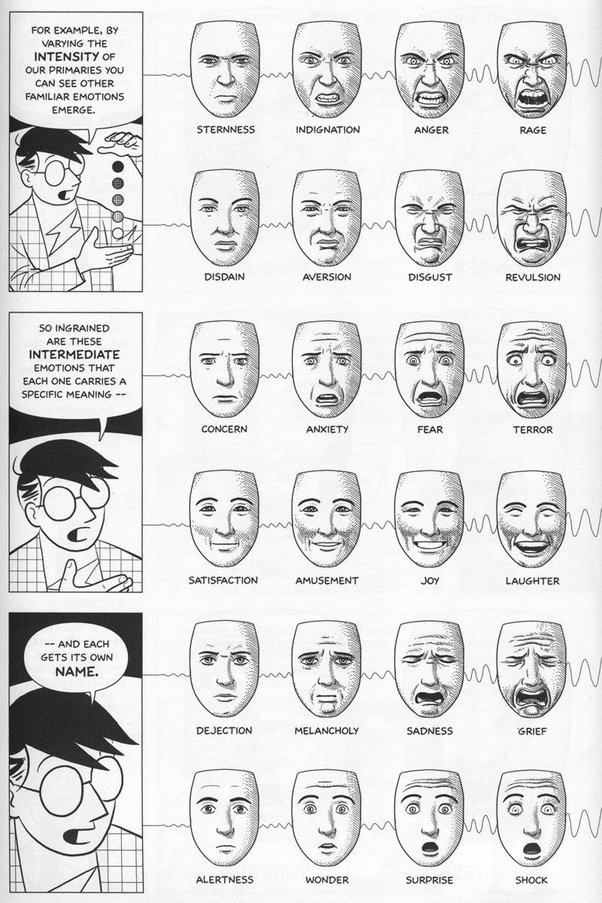

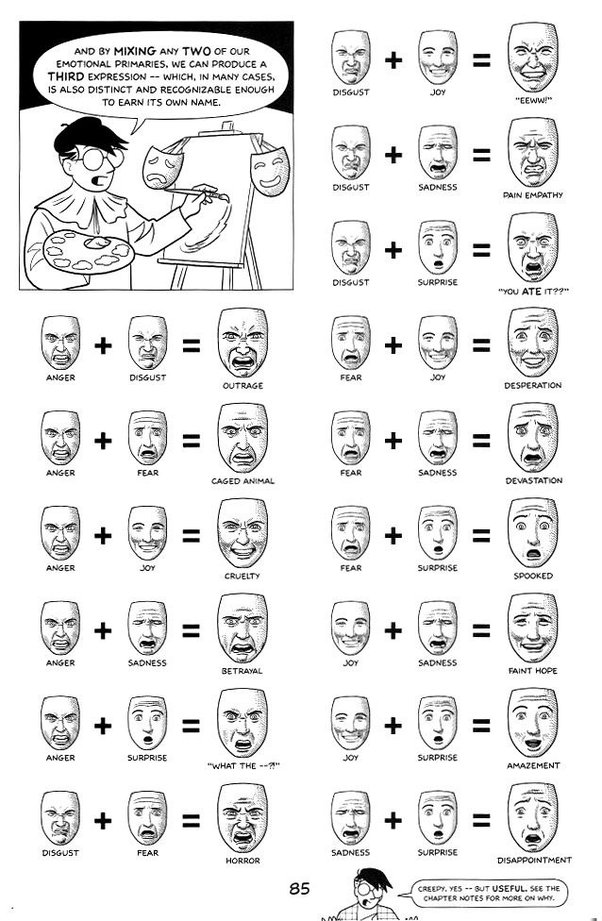

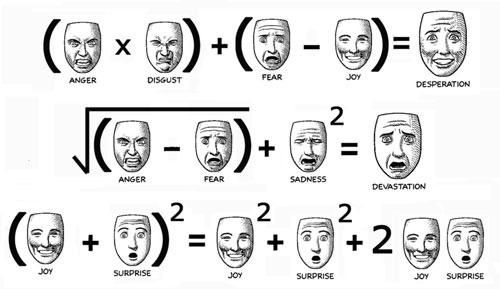

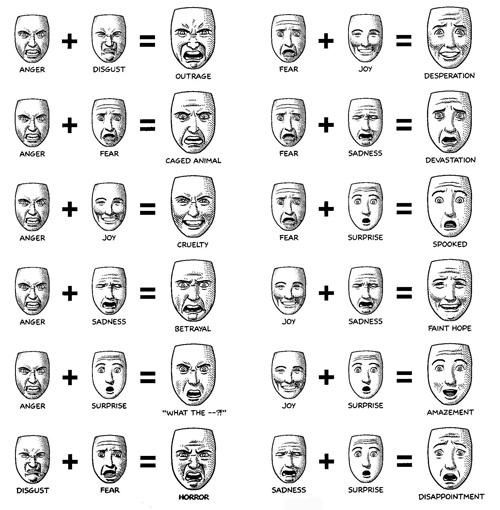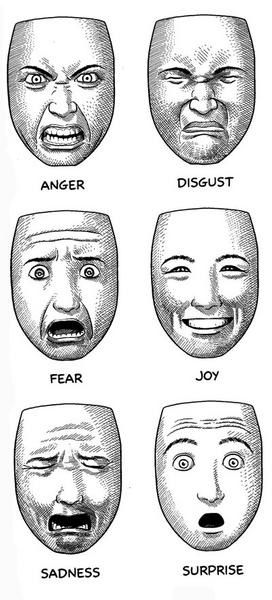

## Некоторые вспомогательные вещи, которые могут пригодиться

In [ ]:
import re
pattern = re.compile("fer\d+.png")
bool(pattern.match('fer000001.png')),   bool(pattern.match('mfe000001.png'))

(True, False)

# **Импорт библиотек**

In [ ]:
# Counter используется при оценке сбалансированности датасета.
# Раздел "Посмотрим распределение классов"
from collections import Counter 
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


import torch
import random # планирую делать воспроизводимые эксперименты

import tensorflow as tf

# три импорта ниже для визуализации матрицы ошибок
!pip install --upgrade mlxtend
from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Подготовка датасета

## Постановка задачи

В итоге выполнения данного раздела получется датасет, который:
* Яляется объединением изображенний FER2013 и меток FER+
* Очищен от непригодных изображений

Он имеет следующие колонки:

* Usage - к какому сету относится изображение (Training / PublicTest / PrivateTest)
* сколько человек проголосовало за каждую из эмоций neutral, happy, surprised, sad, angry, fearful
* most_popular_label - наиболее популярная метка для данного иображения. 
* pixels - пиксели изображения 48x48, записанные в одну строку
* FER2013_index - номер экземляра в датасете FER2013

Если наиболее популярная метка - unknow, NF, contemptious или disgusted, изображение удаляется из датасета

<br>
удаленные столбцы:

* disgusted, contemptious, unknown, NF
* Image name


## Информация о FER2013 и Fer+

В FER2013:
* Столбец Usage отвечает за отнесение к выборкам (обучающая - Training, валидационная - PublicTest и тестовая - PrivateTest)
* Столбец pixels содержит строки со значениями пикселей изображений (целые числа от 0 до 255, разделенные пробелом)
* Столбец emotion содержит метки (целые числа от 0 до 6): 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


В FerPlus:
* строка с инндексом i в FerPlus описывает изображение из строки i в FER2013
* столбец Usage повторяет Usage из FER2013
* столбцы neutral, happiness, surprise, sadness,	anger,	disgust,	fear,	contempt содержат число разметчиков проголосовавших за данную эмоцию (всего 10 человек голосовало за каждую из эмоций)
* Также разметчики могли голосовать за эмоцию unknown, если считали, что эта эмоция ен вписывается в множество из предыдущего списка и NF, если на изображении нет лица


В FerPlus название картинки не всегда соответствует индексу. Как я понял, это из-за картинок, на которых нет людей: после них иногда идет следующий индекс, относительно индекса предыдущей картинки, осдержащей лицо 

## Получим dataframe data с изображениями из FER2013 и метками из Fer+

### Загрузим датасеты

In [ ]:
# ссылка на датасет FER2013
pixels_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1kiq18_NOcN9O6lUPKo4HxP1fcuLTkCx-'

# ссылка на датасет FerPlus (Misrosoft)
labels_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1fEywvRBHips0KtsSl10rTaMaBME0pQsh'

In [ ]:
pixels = pd.read_csv(pixels_link)
pixels.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
labels_df = pd.read_csv(labels_link)
labels_df.head()

Usage      Image name  neutral  happiness  surprise  sadness  anger  \
0  Training  fer0000000.png        4          0         0        1      3   
1  Training  fer0000001.png        6          0         1        1      0   
2  Training  fer0000002.png        5          0         0        3      1   
3  Training  fer0000003.png        4          0         0        4      1   
4  Training  fer0000004.png        9          0         0        1      0   

   disgust  fear  contempt  unknown  NF  
0        2     0         0        0   0  
1        0     0         0        2   0  
2        0     0         0        1   0  
3        0     0         0        1   0  
4        0     0         0        0   0

### Объединим метки и пиксели

In [ ]:
data = labels_df.join(pixels.drop(axis = 1, columns = ['Usage', 'emotion']))
data['FER2013_index'] = data.index
original_data = data
data.head()

Usage      Image name  neutral  happiness  surprise  sadness  anger  \
0  Training  fer0000000.png        4          0         0        1      3   
1  Training  fer0000001.png        6          0         1        1      0   
2  Training  fer0000002.png        5          0         0        3      1   
3  Training  fer0000003.png        4          0         0        4      1   
4  Training  fer0000004.png        9          0         0        1      0   

   disgust  fear  contempt  unknown  NF  \
0        2     0         0        0   0   
1        0     0         0        2   0   
2        0     0         0        1   0   
3        0     0         0        1   0   
4        0     0         0        0   0   

                                              pixels  FER2013_index  
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0  
1  151 150 147 155 148 133 111 140 170 174 182 15...              1  
2  231 212 156 164 174 138 161 173 182 200 106 38...              2  
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3  
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4

## Определим кодирование эмоций, переименуем столбцы

In [ ]:
# задание преобразований из чисел в эмоции и наоборот
emotions = ('happy', 'sad', 'angry', 'neutral', 'surprised', 'fearful', 'contemptious', 'disgusted')
emotion_dict = {emotions[i] : i for i in range(len(emotions))}

In [ ]:
data = data.rename(columns={"happiness": "happy", "surprise": "surprised", "sadness": "sad", "anger": "angry", "fear": "fearful", "contempt": "contemptious", "disgust": "disgusted"})
data.head()

Usage      Image name  neutral  happy  surprised  sad  angry  disgusted  \
0  Training  fer0000000.png        4      0          0    1      3          2   
1  Training  fer0000001.png        6      0          1    1      0          0   
2  Training  fer0000002.png        5      0          0    3      1          0   
3  Training  fer0000003.png        4      0          0    4      1          0   
4  Training  fer0000004.png        9      0          0    1      0          0   

   fearful  contemptious  unknown  NF  \
0        0             0        0   0   
1        0             0        2   0   
2        0             0        1   0   
3        0             0        1   0   
4        0             0        0   0   

                                              pixels  FER2013_index  
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0  
1  151 150 147 155 148 133 111 140 170 174 182 15...              1  
2  231 212 156 164 174 138 161 173 182 200 106 38...              2  
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3  
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4

## Добавим столбец с наиболее популярной эмоцией

* получить кусок таблицы, содержащий только эмоции
* для каждой строки подтаблицы найти максимум
* для каждой строки вывести название столбца, в котором максимум

In [ ]:
# only_labels содержит часть таблицы, содержащую только эмоции
only_labels = data[['happy', 'sad', 'angry', 'neutral', 'surprised', 'fearful', 'contemptious', 'disgusted', 'unknown', 'NF']]

# Добавим в data столбец с наиболее популярной меткой.
# Для этого получим pandas series, каждая строка которого
# является названием столбца таблицы only_labels, значение в котором максимально
# для данной строки only_labels.
data['most_popular_label'] = only_labels.idxmax(axis=1)
data.head()

Usage      Image name  neutral  happy  surprised  sad  angry  disgusted  \
0  Training  fer0000000.png        4      0          0    1      3          2   
1  Training  fer0000001.png        6      0          1    1      0          0   
2  Training  fer0000002.png        5      0          0    3      1          0   
3  Training  fer0000003.png        4      0          0    4      1          0   
4  Training  fer0000004.png        9      0          0    1      0          0   

   fearful  contemptious  unknown  NF  \
0        0             0        0   0   
1        0             0        2   0   
2        0             0        1   0   
3        0             0        1   0   
4        0             0        0   0   

                                              pixels  FER2013_index  \
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0   
1  151 150 147 155 148 133 111 140 170 174 182 15...              1   
2  231 212 156 164 174 138 161 173 182 200 106 38...              2   
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3   
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4   

  most_popular_label  
0            neutral  
1            neutral  
2            neutral  
3                sad  
4            neutral

## Определим вывод изображений из таблицы data

Определим функцию, принимающую список индексов FER2013 и выводящую для каждого индекса изображение

In [ ]:
def str_series_to_ndarray(str_ser):
    """
    Получает на вход pd.Series из строк яркостей пикселей
    Возвращает двумерный numpy массив,
    где строки - массивы пикселей изображений
    """
    return np.array(
        [np.fromstring(x, dtype='float32', sep=' ') for x in str_ser])

In [ ]:
def plot_images_from_idx(idx: List[int]):
    images_cnt = len(idx)
    fig, axs = plt.subplots(
        nrows = 1, ncols = images_cnt, figsize=(3.5 * images_cnt, 3.5))
    if images_cnt == 1:  # для унификации кода
        axs = [axs]
    for plot_index, FER2013_index in enumerate(idx):
        # print(plot_index, img_dataset_index)
        axs[plot_index].set_axis_off()
        image = str_series_to_ndarray(
            data[data.FER2013_index == FER2013_index]['pixels']).reshape(48,48)
        axs[plot_index].imshow(image, cmap='gray')
        axs[plot_index].set_title(f"FER2013_index: {FER2013_index}")

## Поиск и удаление неподходящих изображений

In [ ]:
# Множетство индексов удаленных изображений
deleted_indexes = set()

### Удаление строк, где наиболее популярным решением было презрение или отвращение

In [ ]:
contemptious_idx = data[data['most_popular_label'] == 'contemptious'].index
disgust_idx = data[data['most_popular_label'] == 'disgusted'].index

unnesessosary_emotions_indexes = list(contemptious_idx) + list(disgust_idx)
deleted_indexes.update(unnesessosary_emotions_indexes) 

data = data.drop(unnesessosary_emotions_indexes)

### Удалим неподходящие изображения, проанализировав столбец NF

В результате работы блоков данного раздела отбираются изображения, подходящие для решения данной задачи, у которых есть хоть 1 метка в столбце NF. Остальные изображения с метками NF из датасета удаляются

In [ ]:
print(f"количество фото, о которых хотябы 1 разметчик сказал, что оно не содержит лиц: {labels_df[labels_df['NF'] != 0].shape[0]}")
print(f"количество фото, о которых все разметчики сказали, что оно не содержит лиц: {labels_df[labels_df['NF'] == 10].shape[0]}")

количество фото, о которых хотябы 1 разметчик сказал, что оно не содержит лиц: 349
количество фото, о которых все разметчики сказали, что оно не содержит лиц: 176


Удалим изображения, о которых все разметчики сказали, что лиц нет

Перед этим посмотрим на них из интереса

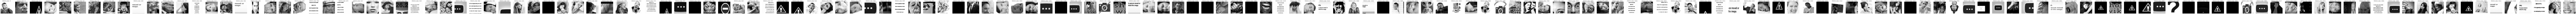

In [ ]:
plot_images_from_idx(list(data[data['NF'] == 10].index))

In [ ]:
deleted_indexes.update(list(data[data['NF'] == 10].index))
data = data.drop(data[data['NF'] == 10].index)

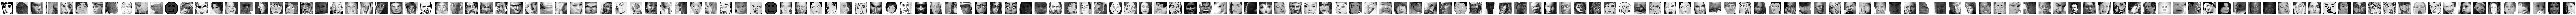

In [ ]:
plot_images_from_idx(list(data[data['NF'] != 0].index))

Изображения, о которых некоторые, но не все, сказали, что лица нет содержат:
* мультикапликационых персонажей
* обрезанные лица
* лица в профиль
* частично закрытые лица

Большинство этих изображений не подходят в контексте решаемой задачи. Индексы изображений, которые нужно сохранить были выписаны вручную ниже (список appropriate_NF)

In [ ]:
appropriate_NF = [11973, 10050, 11736, 12371, 13647, 14215, 14526, 15688, 15900, 15988, 17362, 17405, 18140, 18616, 22357, 23923, 24494, 26979, 31858, 32963, 33806, 33920, 34662, 34681, 34682, 34777, 34824, 35367, 35410, 35570, 35676]

In [ ]:
nf_list = list(data[data['NF'] != 0].index)

In [ ]:
# Убедимся, что не выписали случайно индексы, не принадлежащие списку NF индексов
for i in appropriate_NF:
    if i not in nf_list:
        print(i)

14215


In [ ]:
# Получим список изобажений, отмеченных кем-то как NF, и действительно являющихся неподходящими
inappropriate_NF = []
for nf in nf_list:
    if nf not in appropriate_NF:
        inappropriate_NF.append(nf)

In [ ]:
deleted_indexes.update(inappropriate_NF) 
# Удалим изображения по индексам из inappropriate_NF 
data = data.drop(inappropriate_NF)

### Посмотрим столбец unknown, удалим строки, где это - самая популярная метка

In [ ]:
data[data['unknown'] != 0].shape[0],  data[data['unknown'] >= 9].shape[0], data[data['unknown'] == 1].shape[0], data[data['unknown'] == 2].shape[0], data[data['unknown'] > 4].shape[0],

(11557, 0, 8072, 2462, 79)

In [ ]:
pop_unknown_idx = list(list(data[data['most_popular_label'] == 'unknown'].index))

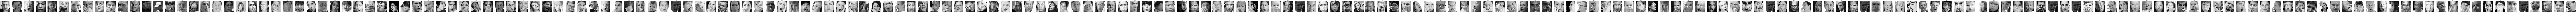

In [ ]:
plot_images_from_idx(pop_unknown_idx)

In [ ]:
len(pop_unknown_idx)

219

In [ ]:
deleted_indexes.update(pop_unknown_idx)

In [ ]:
data = data.drop(pop_unknown_idx)

## Подведение итогов по подготовке датасета

Подготовка датсета завершена.
Было удалено 999 неподходящих изображений

In [ ]:
# Из исходного датасета суммарно бвло удалено 999 изобажений
original_data.shape[0] - data.shape[0]

999

In [ ]:
data.head()

Usage      Image name  neutral  happy  surprised  sad  angry  disgusted  \
0  Training  fer0000000.png        4      0          0    1      3          2   
1  Training  fer0000001.png        6      0          1    1      0          0   
2  Training  fer0000002.png        5      0          0    3      1          0   
3  Training  fer0000003.png        4      0          0    4      1          0   
4  Training  fer0000004.png        9      0          0    1      0          0   

   fearful  contemptious  unknown  NF  \
0        0             0        0   0   
1        0             0        2   0   
2        0             0        1   0   
3        0             0        1   0   
4        0             0        0   0   

                                              pixels  FER2013_index  \
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0   
1  151 150 147 155 148 133 111 140 170 174 182 15...              1   
2  231 212 156 164 174 138 161 173 182 200 106 38...              2   
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3   
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4   

  most_popular_label  
0            neutral  
1            neutral  
2            neutral  
3                sad  
4            neutral

Удалим столбцы disgusted, contemptious, unknown, NF, Image name

Напомню, что строки, где disgusted, contemptious и unknown наиболее популярны удалены, изображения без лиц - тоже удалены

In [ ]:
data = data.drop(columns=['Image name', 'disgusted', 'unknown', 'contemptious', 'NF'])
data.head()

Usage  neutral  happy  surprised  sad  angry  fearful  \
0  Training        4      0          0    1      3        0   
1  Training        6      0          1    1      0        0   
2  Training        5      0          0    3      1        0   
3  Training        4      0          0    4      1        0   
4  Training        9      0          0    1      0        0   

                                              pixels  FER2013_index  \
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0   
1  151 150 147 155 148 133 111 140 170 174 182 15...              1   
2  231 212 156 164 174 138 161 173 182 200 106 38...              2   
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3   
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4   

  most_popular_label  
0            neutral  
1            neutral  
2            neutral  
3                sad  
4            neutral

In [ ]:
# убедимся, что в most_popular_label только эмоции из множества neutral, happy, surprised, sad, angry, fearful
data['most_popular_label'].unique()

array(['neutral', 'sad', 'happy', 'surprised', 'angry', 'fearful'],
      dtype=object)

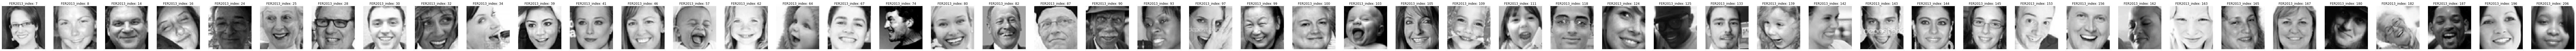

In [ ]:
plot_images_from_idx(list(data[data['most_popular_label'] == 'happy'].index)[:50])

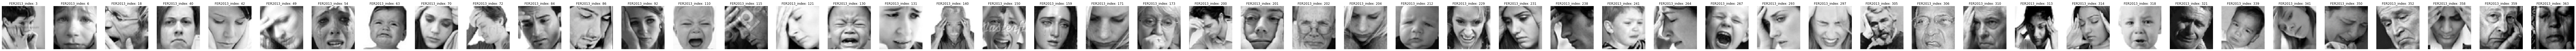

In [ ]:
plot_images_from_idx(list(data[data['most_popular_label'] == 'sad'].index)[:50])

In [ ]:
data.to_csv('clean_data.csv')  

# **Загрузим датасет, получаемый выполнением всех клеток выше**

In [ ]:
clean_data_link = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1OAsi9Y_0SwlZI016B576nwsCd6_YqSV-'

In [ ]:
data = pd.read_csv(clean_data_link)

# Все, что выше достаточно аккуратно и логично

# Подход, где каждое изображение имеет одну метку

В результате этого блока мы получим данные в следующем виде:

* X_train, X_val, X_test - двумерные массивы, строки которых - векторы пикселей изображений

* Вy_train, y_val, y_test - двумерные массивы, строки которых - векторы, где по индексу метки хранится 1, по остальным индексам - 0


In [ ]:
data.head()

Unnamed: 0     Usage  neutral  happy  surprised  sad  angry  fearful  \
0           0  Training        4      0          0    1      3        0   
1           1  Training        6      0          1    1      0        0   
2           2  Training        5      0          0    3      1        0   
3           3  Training        4      0          0    4      1        0   
4           4  Training        9      0          0    1      0        0   

                                              pixels  FER2013_index  \
0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...              0   
1  151 150 147 155 148 133 111 140 170 174 182 15...              1   
2  231 212 156 164 174 138 161 173 182 200 106 38...              2   
3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...              3   
4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...              4   

  most_popular_label  
0            neutral  
1            neutral  
2            neutral  
3                sad  
4            neutral

In [ ]:
data['most_popular_label'].unique()

array(['neutral', 'sad', 'happy', 'surprised', 'angry', 'fearful'],
      dtype=object)

In [ ]:
# задание преобразований из чисел в эмоции и наоборот
emotions = ('happy', 'sad', 'angry', 'neutral', 'surprised', 'fearful')
emotion_dict = {emotions[i] : i for i in range(len(emotions))}

In [ ]:
train_data = data[data.Usage=='Training']
val_data = data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((27946, 11), (3488, 11), (3454, 11))

In [ ]:
X_train_strings = train_data['pixels']
X_val_strings = val_data['pixels']
X_test_strings = test_data['pixels']

In [ ]:
def str_series_to_ndarray(str_ser):
    """
    Получает на вход pd.Series из строк яркостей пикселей
    Возвращает двумерный numpy массив,
    где строки - массивы пикселей изображений
    """
    return np.array(
        [np.fromstring(x, dtype='float32', sep=' ') for x in str_ser])

In [ ]:
X_train = X_train_lines = str_series_to_ndarray(X_train_strings)
X_val = X_val_lines = str_series_to_ndarray(X_val_strings)
X_test = X_test_lines = str_series_to_ndarray(X_test_strings)

метки в виде чисел от 0 до 5 могут при визуализации результатов и для матрицы ошибок

In [ ]:
def get_encoded_labels_from_pd_series(x):
    return np.fromiter(
        map(lambda x: emotion_dict[x], x['most_popular_label']),
        dtype=np.int32)

In [ ]:
y_train_nums = get_encoded_labels_from_pd_series(train_data)
y_val_nums = get_encoded_labels_from_pd_series(val_data)
y_test_nums = get_encoded_labels_from_pd_series(test_data)

# возможно, не будут использованы, так как можно заменить на y_train.argmax(axis=1)

In [ ]:
y_train = y_train_original = pd.get_dummies(y_train_nums).to_numpy()
y_val = y_val_original = pd.get_dummies(y_val_nums).to_numpy()
y_test = y_test_original = pd.get_dummies(y_test_nums).to_numpy()

Сделаем из выпрямленных в векторы изображений матрицы 48x48. Глубину (число каналов, равное единице) добавлять не будем пока что, так как в зависимости от фреймворка, за нее отвечает арзная размерость

Размерность = [число фотогрфий в выборке, 48, 48)

In [ ]:
X_train = X_train.reshape(-1,48,48)
X_val = X_val.reshape(-1,48,48)
X_test = X_test.reshape(-1,48,48)

# Знакомство с датасетом

на данный момент тип данных - массивы numpy. Размеры выборок можно посмотреть ниже

In [ ]:
type(X_train) == type(X_val) == type(X_test) == np.ndarray, \
    X_train.shape, X_val.shape, X_test.shape

(True, (27946, 48, 48), (3488, 48, 48), (3454, 48, 48))

## Посмотрем примеры изображений из датасета

мне кажется, нужно
* написать вывод списка изображений на экран
* поиск изображения по индексу FER+
* поиск индекса FER пои индексу FER+
* поиск индекса FER+ по паре (эмоция, номер изображения с данной эмоцией)

### Выведем несколько картинок

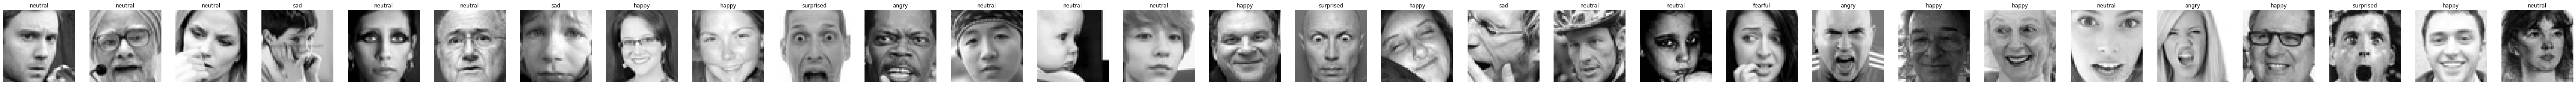

In [ ]:
y_train_examples = y_train_nums[0:30]
X_train_examples = X_train[0:30]
images_cnt = len(y_train_examples)
fig, axs = plt.subplots(
    nrows = 1, ncols = images_cnt, figsize=(3.5 * images_cnt, 3.5))
for i, (image, label) in enumerate(zip(X_train_examples, y_train_examples)):
    axs[i].set_axis_off()
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(emotions[label])
    


## Посмотрим распределение классов

In [ ]:
Counter(data['most_popular_label'])


Counter({'neutral': 11977,
         'sad': 4969,
         'happy': 9486,
         'surprised': 4371,
         'angry': 3270,
         'fearful': 815})

In [ ]:
data[data['Usage'] == 'Training']['most_popular_label']

0        neutral
1        neutral
2        neutral
3            sad
4        neutral
          ...   
27941    fearful
27942      angry
27943        sad
27944    neutral
27945    neutral
Name: most_popular_label, Length: 27946, dtype: object

Нетрудно заметить, что это несбалансированная выборка

In [ ]:
def plot_distributions():
    num_labels = 6
    num_histograms = 4
    fig, axs = plt.subplots(1, num_histograms, figsize=(5.8*num_histograms, 4))
    train_count = Counter(data[data['Usage'] == 'Training']['most_popular_label'])
    val_count = Counter(data[data['Usage'] == 'PublicTest']['most_popular_label'])
    test_count = Counter(data[data['Usage'] == 'PrivateTest']['most_popular_label'])
    all_count = Counter(data['most_popular_label'])

    for axs_i, (count, dataset_type) in enumerate(
        [[train_count, 'training'], [val_count, 'validation'],
        [test_count, 'test'], [all_count, 'full dataset']]):
        
        axs[axs_i].bar(
            emotions,
            [count[emotion] for emotion in emotions])
        axs[axs_i].set_title(dataset_type)
        axs[axs_i].grid()

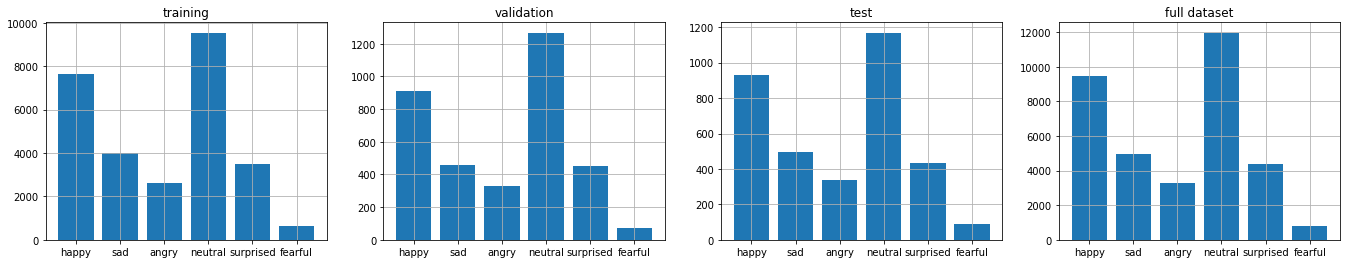

In [ ]:
plot_distributions()

# Аугментация

В качестве аугментации отзеркалим все изображения с пмощью np.flip(X_train, axis=2)

Проверим, как работает команда:

In [ ]:
X_train_flipped = np.flip(X_train, axis = 2)

In [ ]:
"""
emotion_num = emotion_dict['happy']
img_dataset_index = 1
images_num = 2
fig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))

idx = data[data['emotion']==emotion_num].index[img_dataset_index]

for axs_index, dataset in enumerate([X_train, X_train_flipped]):
    print(axs_index)
    axs[axs_index].set_axis_off()
    axs[axs_index].imshow(dataset[idx], cmap='gray')
    axs[axs_index].set_title(emotions[emotion_num])
"""

In [ ]:
X_train_aug = np.concatenate([X_train, X_train_flipped])

In [ ]:
X_train.shape, X_train_aug.shape

In [ ]:
"""
index_orig = 0
index_aug =  index_orig + 28709
idxes = [index_orig, index_aug]
images_num = 2
fig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))

idx = data[data['emotion']==emotion_num].index[img_dataset_index]

for axs_index, (dataset, idx) in enumerate(zip([X_train, X_train_aug], idxes)):
    print(axs_index, idx)
    axs[axs_index].set_axis_off()
    axs[axs_index].imshow(dataset[idx], cmap='gray')
    axs[axs_index].set_title(emotions[emotion_num])
"""

In [ ]:
y_train_aug =  np.concatenate([y_train, y_train])

In [ ]:
y_train_aug.shape

In [ ]:
X_train = X_train_aug
y_train = y_train_aug   

# Аугментация (без нейтральной эмоции)

В качестве аугментации отзеркалим все изображения с пмощью np.flip(X_train, axis=2)

Проверим, как работает команда:

In [ ]:
X_train_flipped = np.flip(X_train[y_train_nums!=3], axis = 2)

In [ ]:
"""
emotion_num = emotion_dict['happy']
img_dataset_index = 1
images_num = 2
fig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))

idx = data[data['emotion']==emotion_num].index[img_dataset_index]

for axs_index, dataset in enumerate([X_train, X_train_flipped]):
    print(axs_index)
    axs[axs_index].set_axis_off()
    axs[axs_index].imshow(dataset[idx], cmap='gray')
    axs[axs_index].set_title(emotions[emotion_num])
"""

"\nemotion_num = emotion_dict['happy']\nimg_dataset_index = 1\nimages_num = 2\nfig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))\n\nidx = data[data['emotion']==emotion_num].index[img_dataset_index]\n\nfor axs_index, dataset in enumerate([X_train, X_train_flipped]):\n    print(axs_index)\n    axs[axs_index].set_axis_off()\n    axs[axs_index].imshow(dataset[idx], cmap='gray')\n    axs[axs_index].set_title(emotions[emotion_num])\n"

In [ ]:
X_train.shape[0], X_train_flipped.shape[0] + X_train[y_train_nums==3].shape[0]

(27946, 27946)

In [ ]:
X_train_aug = np.concatenate([X_train, X_train_flipped])

In [ ]:
X_train_aug.shape[0], X_train[y_train_nums!=3].shape[0] + X_train.shape[0]

(46351, 46351)

In [ ]:
"""
index_orig = 0
index_aug =  index_orig + 28709
idxes = [index_orig, index_aug]
images_num = 2
fig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))

idx = data[data['emotion']==emotion_num].index[img_dataset_index]

for axs_index, (dataset, idx) in enumerate(zip([X_train, X_train_aug], idxes)):
    print(axs_index, idx)
    axs[axs_index].set_axis_off()
    axs[axs_index].imshow(dataset[idx], cmap='gray')
    axs[axs_index].set_title(emotions[emotion_num])
"""

"\nindex_orig = 0\nindex_aug =  index_orig + 28709\nidxes = [index_orig, index_aug]\nimages_num = 2\nfig, axs = plt.subplots(1, images_num, figsize=(3.5 * images_num, 3.5))\n\nidx = data[data['emotion']==emotion_num].index[img_dataset_index]\n\nfor axs_index, (dataset, idx) in enumerate(zip([X_train, X_train_aug], idxes)):\n    print(axs_index, idx)\n    axs[axs_index].set_axis_off()\n    axs[axs_index].imshow(dataset[idx], cmap='gray')\n    axs[axs_index].set_title(emotions[emotion_num])\n"

In [ ]:
y_train_aug =  np.concatenate([y_train, y_train[y_train_nums!=3]])

In [ ]:
y_train_aug.shape

(46351, 6)

In [ ]:
X_train_aug.shape

(46351, 48, 48)

In [ ]:
X_train = X_train_aug
y_train = y_train_aug   

# Предобработки Fer2013

## Нормализация

По умолчанию все X нормализую.

Тем не мнее сохраню ненормализованные с такими названиями, как:  X_train_not_norm

In [ ]:
X_train_not_norm = X_train
X_val_not_norm = X_val
X_test_not_norm = X_test

In [ ]:
X_train.shape

(46351, 48, 48)

In [ ]:
X_train.mean(axis = 0).shape

(48, 48)

Нормализация производится вглубь. Те для каждого пискселя находится среднее значение по выборке. Из каждого пикселя вычитается каждого изображения вычитается среднее значения пикселя с данным индексом по выборке. Затем для каждого "отцентрованного" пискеля находится СКО и делится на него.

Я не уверен в том, наксолько это переносимо на работу с единичными изображениями. Кажется, ни на сколько, и нужно просто делить на 255

In [ ]:
"""
def normalize(X):
    centered_X = X - X.mean(axis = 0)
    normalized_X = centered_X / centered_X.std(axis = 0)
    return normalized_X
"""

def normalize(X):
    return X/255

X_train = X_train_norm_lines = normalize(X_train_not_norm)
X_val = X_val_norm_lines = normalize(X_val_not_norm)
X_test = X_test_norm_lines = normalize(X_test_not_norm)

Для решения проблемы несбалансированности данных (видно в разделе "Посмотрим распределение классов"), мы можем применить OverSampling. Те дублировать случайны экземляры классов с малыми числами объектов, пока датасет не выровняется.

С другой стороны, самым проблемным классом является disgust. Однновременно с этим, я не вижу способов применения отвращения для обработки звучания музыкального инструмента




# Приведем датасет к виду, пригодному для keras

In [ ]:
X_train = X_train_norm_lines.reshape(-1, 48, 48, 1)
X_val = X_val_norm_lines.reshape(-1, 48, 48, 1)
X_test = X_test_norm_lines.reshape(-1, 48, 48, 1)

In [ ]:
#y_train = y_train_original
#y_val = y_val_original
#y_test = y_test_original

Псмотрим новую размерность

In [ ]:
X_train.shape

(46351, 48, 48, 1)

Проверим корректность преобразования:

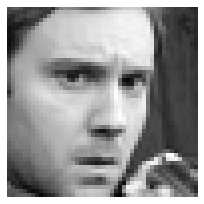

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3.5))
axs.set_axis_off()
axs.imshow(X_train[0].reshape((48, 48)), cmap='gray')

# KMUnet

## Импорты

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras.metrics import Precision 

## mod1

In [ ]:
num_labels = 6
batch_size = 64
epochs = 5 # изменить
width, height = 48, 48

model = tf.keras.Sequential([
    tfl.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    tfl.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tfl.Dropout(0.25),

    tfl.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    tfl.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tfl.Dropout(0.3),

    tfl.Conv2D(112, kernel_size=(3, 3), activation='relu'),
    tfl.AveragePooling2D(pool_size=(3, 3), strides=(1, 1)),
    tfl.Dropout(0.3),

    tfl.Flatten(),

    tfl.Dense(464, activation='relu'),
    tfl.Dropout(0.4),

    tfl.Dense(384, activation='relu'),
    tfl.Dropout(0.35),

    tfl.Dense(num_labels, activation='softmax'),
])
    
model.summary()

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy', Precision()])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_11 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 21, 21, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 19, 19, 96)        55392     
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 17, 96)        83040     
                                                      

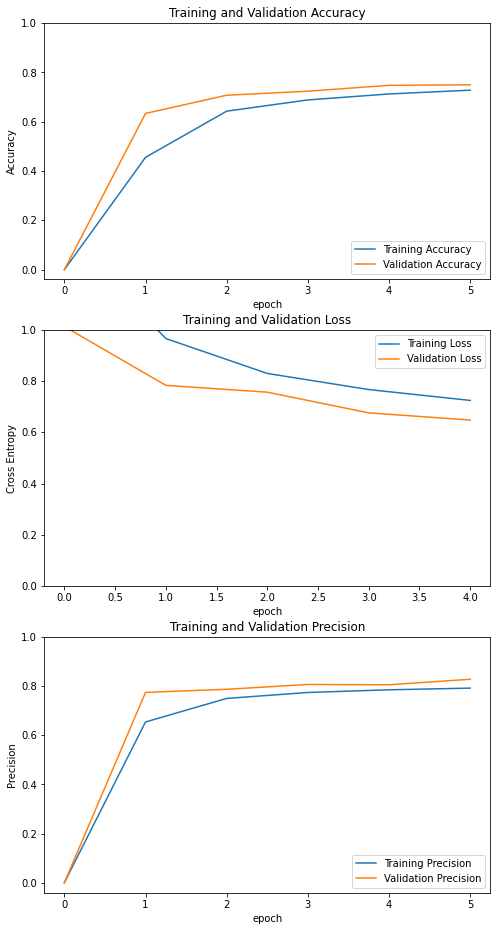

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = [0.] + history.history['precision_1']
val_precision = [0.] + history.history['val_precision_1']

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')


plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')



plt.subplot(3, 1, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')



plt.show()

In [ ]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

## mod2

In [ ]:
num_labels = 6
batch_size = 64
epochs = 40 # изменить
width, height = 48, 48

model = tf.keras.Sequential([
    tfl.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    tfl.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tfl.Dropout(0.35),

    tfl.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    tfl.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tfl.Dropout(0.35),

    tfl.Conv2D(112, kernel_size=(3, 3), activation='relu', padding = 'same'),
    tfl.Conv2D(112, kernel_size=(3, 3), activation='relu'),
    tfl.AveragePooling2D(pool_size=(3, 3), strides=(1, 1)),

    tfl.Flatten(),
    tfl.Dropout(0.45),

    tfl.Dense(430, activation='relu'),
    tfl.Dropout(0.4),

    tfl.Dense(200, activation='relu'),
    tfl.Dropout(0.35),

    tfl.Dense(100, activation='relu'),
    tfl.Dropout(0.35),

    tfl.Dense(num_labels, activation='softmax'),
])
    
model.summary()

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy', Precision()])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 96)        55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 96)        83040     
                                                        

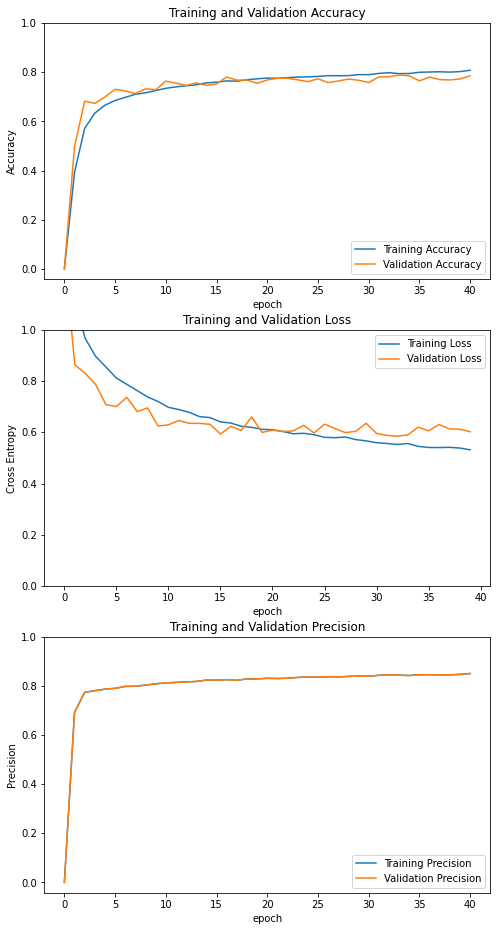

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = [0.] + history.history['precision']
val_precision = [0.] + history.history['precision']

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')


plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')



plt.subplot(3, 1, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')



plt.show()

In [ ]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

## Модель из старого блокнота на 20.04.22 21:10 наиболее стабильный результат (минимальное переобучение). При этом максимальная точность (после 50 эпохи выше 61%)

In [ ]:
num_labels = 7
batch_size = 64
epochs = 60 # изменить
width, height = 48, 48


model = Sequential()


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.55))



model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.55))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Flatten())

model.add(Dense(3072, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 64)        36928     
                                                        

In [ ]:
num_labels = 7
batch_size = 64
epochs = 60 # изменить
width, height = 48, 48


model = Sequential()


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.55))



model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.55))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Flatten())

model.add(Dense(3072, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy', Precision()])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          shuffle=True)


fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 21, 21, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 64)        36928     
                                                      

In [ ]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

# Загрузка модели из файлов

In [ ]:
from tensorflow.keras.models import model_from_json
import os


def _load_nn(dir_='', model_name = 'fer.json', weights_name = 'fer.h5'):
    # загрузим модель
    model = model_from_json(open(os.path.join(dir_, model_name), "r").read())
    # загрузим веса
    model.load_weights(os.path.join(dir_, weights_name))
    return model

model = _load_nn()

# Тестирование моделей и оценка предсказаний

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
test_output = model.predict(X_test)
val_output = model.predict(X_val)
print(accuracy_score(y_test.argmax(axis=1), test_output.argmax(axis=1)))
print(accuracy_score(y_val.argmax(axis=1), val_output.argmax(axis=1)))
print(roc_auc_score(
    y_test,
    test_output,
    multi_class = 'ovo',
    average = 'macro',
    ))
print(roc_auc_score(
    y_val,
    val_output,
    multi_class = 'ovo',
    average = 'macro',
    ))


0.7860451650260567
0.7852637614678899
0.951839308930146
0.9530504640976907


In [ ]:
y_test.argmax(axis = 1)

array([1, 3, 4, ..., 2, 0, 1])

In [ ]:
"""
def find_TP(y, y_hat):
   # counts the number of true positives (y = 1, y_hat = 1)
   return sum((y == 1) & (y_hat == 1))
def find_FN(y, y_hat):
   # counts the number of false negatives (y = 1, y_hat = 0) Type-II error
   return sum((y == 1) & (y_hat == 0))
def find_FP(y, y_hat):
   # counts the number of false positives (y = 0, y_hat = 1) Type-I error
   return sum((y == 0) & (y_hat == 1))
def find_TN(y, y_hat):
   # counts the number of true negatives (y = 0, y_hat = 0)
   return sum((y == 0) & (y_hat == 0))
"""

**А не нужно ли перевести в режим предсказаний?**

In [ ]:
test_output = model.predict(X_test)

Нужно отметить, что во время обучения и на этапе оценки точности нам не обязательно иметь выходные данные, интерпретирующиеся как вероятности. Поэтому с целью оптимизации вычислений софтмакс не применяется. Однако в продакшене нужно в конец добавить слой софтмакса, как ниже

### Матрица ошибок

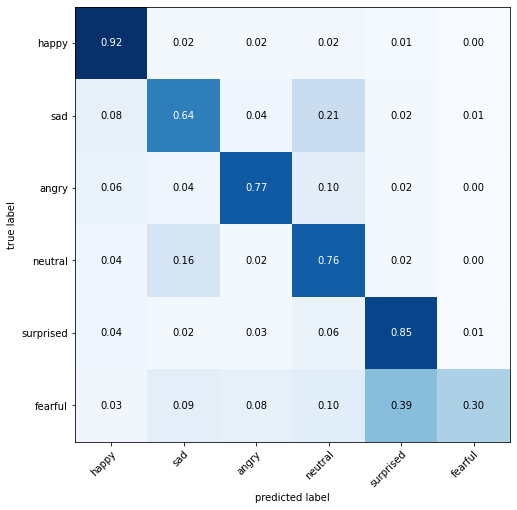

In [ ]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), test_output.argmax(axis=1))
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions,
                                figsize=(8, 8))
fig.show()

# Xception keras

In [ ]:
xception = tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(48,48,1),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)

xception.compile(loss=categorical_crossentropy,
                 optimizer=Adam(),
                 metrics=['accuracy'])

xception.fit(X_train, y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_val),
          shuffle=True)

ValueError: ignored

# VGG keras

In [ ]:
vgg = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(48,48,1),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)

In [ ]:
vgg.compile(loss=categorical_crossentropy,
                 optimizer=Adam(),
                 metrics=['accuracy'])

In [ ]:
vgg.fit(X_train, y_train,
        batch_size=64,
        epochs=30,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=True)

Epoch 1/30
449/449 [==============================] - 79s 142ms/step - loss: 2.3350 - accuracy: 0.2447 - val_loss: 1.8188 - val_accuracy: 0.2494
Epoch 2/30
449/449 [==============================] - 62s 138ms/step - loss: 1.8128 - accuracy: 0.2513 - val_loss: 1.8128 - val_accuracy: 0.2494
Epoch 3/30
449/449 [==============================] - 61s 136ms/step - loss: 1.8120 - accuracy: 0.2513 - val_loss: 1.8145 - val_accuracy: 0.2494
Epoch 4/30
449/449 [==============================] - 61s 136ms/step - loss: 1.8110 - accuracy: 0.2513 - val_loss: 1.8135 - val_accuracy: 0.2494
Epoch 5/30
449/449 [==============================] - 61s 136ms/step - loss: 1.8108 - accuracy: 0.2513 - val_loss: 1.8122 - val_accuracy: 0.2494
Epoch 6/30
449/449 [==============================] - 61s 136ms/step - loss: 1.8109 - accuracy: 0.2513 - val_loss: 1.8141 - val_accuracy: 0.2494
Epoch 7/30
449/449 [==============================] - 61s 136ms/step - loss: 1.8109 - accuracy: 0.2513 - val_loss: 1.8109 - val_ac

# Матрица ошибок (вообще)

**этот блок не относится к конкретной сети и его можно удалить, так как у сетей я сделал свои аналогичные блоки**

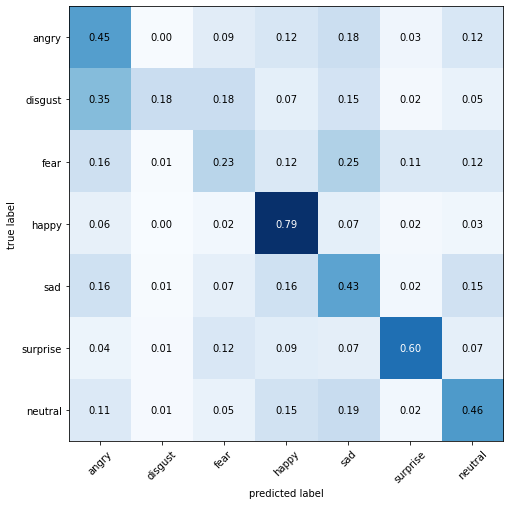

In [ ]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions,
                                figsize=(8, 8))
fig.show()

In [ ]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=False,
                                show_absolute=True,
                                class_names=emotions,
                                figsize=(8, 8))
fig.show()

## рассмотрим результаты три метода нормировки (неформально)

* При нормировке по действительным значениям (по строкам), диагональ дает в процентах выражает, насколько часто мы верно предсказывали данную эмоцию, относительно того, сколько раз мы эту эмоцию **встретили**. Получается, это обобщение метрики **presision**

* При нормирвке по предсказаниям (по столбцам), диагональ выражает, насколько часто мы верно предсказывали данную эмоцию, относительно того, сколько раз мы эту эмоцию **предсказали**. Получается, это обобщение метрики **recall**


* Без нормировки мы получаем таблицу, элемент с индексами i, j которой показывает сколько элементов с эмоцией i были отнесены к классу с эмоцией j

In [ ]:
confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), normalize = 'pred')

array([[0.31372549, 0.19354839, 0.12874251, 0.08967391, 0.18660287,
        0.05      , 0.11782946],
       [0.04656863, 0.32258065, 0.0239521 , 0.00905797, 0.00478469,
        0.00454545, 0.00465116],
       [0.12990196, 0.22580645, 0.34131737, 0.08333333, 0.14992026,
        0.18863636, 0.13178295],
       [0.13235294, 0.        , 0.10479042, 0.56431159, 0.13556619,
        0.06818182, 0.08062016],
       [0.20833333, 0.09677419, 0.17365269, 0.09601449, 0.31419458,
        0.07045455, 0.17674419],
       [0.03921569, 0.09677419, 0.10479042, 0.04076087, 0.04944179,
        0.55      , 0.06821705],
       [0.12990196, 0.06451613, 0.12275449, 0.11684783, 0.15948963,
        0.06818182, 0.42015504]])

In [ ]:
cm_all = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), normalize = 'all')
cm_all

array([[0.03566453, 0.00167177, 0.01198105, 0.02758429, 0.03259961,
        0.00612984, 0.02117581],
       [0.00529395, 0.00278629, 0.00222903, 0.00278629, 0.00083589,
        0.00055726, 0.00083589],
       [0.01476734, 0.0019504 , 0.03176372, 0.02563388, 0.02619114,
        0.02312622, 0.02368348],
       [0.01504597, 0.        , 0.00975202, 0.17358596, 0.02368348,
        0.00835887, 0.01448872],
       [0.02368348, 0.00083589, 0.01616049, 0.02953469, 0.05488994,
        0.0086375 , 0.03176372],
       [0.00445807, 0.00083589, 0.00975202, 0.01253831, 0.0086375 ,
        0.06742825, 0.01225968],
       [0.01476734, 0.00055726, 0.01142379, 0.03594316, 0.02786291,
        0.00835887, 0.0755085 ]])

In [ ]:
for i in range (7):
    print(f"{emotions[i]}, {cm_all[i][i]}")

angry, 0.03566453050989134
disgust, 0.0027862914460852605
fear, 0.03176372248537197
happy, 0.17358595709111174
sad, 0.05488994148787963
surprise, 0.06742825299526331
neutral, 0.07550849818891056


In [ ]:
confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), normalize = 'pred')

array([[0.31372549, 0.19354839, 0.12874251, 0.08967391, 0.18660287,
        0.05      , 0.11782946],
       [0.04656863, 0.32258065, 0.0239521 , 0.00905797, 0.00478469,
        0.00454545, 0.00465116],
       [0.12990196, 0.22580645, 0.34131737, 0.08333333, 0.14992026,
        0.18863636, 0.13178295],
       [0.13235294, 0.        , 0.10479042, 0.56431159, 0.13556619,
        0.06818182, 0.08062016],
       [0.20833333, 0.09677419, 0.17365269, 0.09601449, 0.31419458,
        0.07045455, 0.17674419],
       [0.03921569, 0.09677419, 0.10479042, 0.04076087, 0.04944179,
        0.55      , 0.06821705],
       [0.12990196, 0.06451613, 0.12275449, 0.11684783, 0.15948963,
        0.06818182, 0.42015504]])

#Omar


In [ ]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

def simple_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def simpler_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(5, 5), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Flatten())
    #model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def tiny_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(8, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

def big_XCEPTION(input_shape, num_classes):
    img_input = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


if __name__ == "__main__":
    input_shape = (48, 48, 1)
    num_classes = 6
    # model = big_XCEPTION(input_shape, num_classes)
    #model.summary()
    #model = mini_XCEPTION(input_shape, num_classes)
    #model.summary()
    model = tiny_XCEPTION(input_shape, num_classes)
    #model.summary()
    #model = simple_CNN((48, 48, 1), num_classes)
    model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_62 (Conv2D)             (None, 46, 46, 5)    45          ['input_4[0][0]']                
                                                                                                  
 batch_normalization_30 (BatchN  (None, 46, 46, 5)   20          ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 46, 46, 5)    0           ['batch_normalization_30[0]

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy', Precision()])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/40
874/874 [==============================] - 26s 26ms/step - loss: 1.3359 - accuracy: 0.5075 - precision_9: 0.6633 - val_loss: 1.2122 - val_accuracy: 0.5722 - val_precision_9: 0.6944
Epoch 2/40
874/874 [==============================] - 21s 24ms/step - loss: 1.0650 - accuracy: 0.6118 - precision_9: 0.7264 - val_loss: 1.0295 - val_accuracy: 0.6164 - val_precision_9: 0.7042
Epoch 3/40
874/874 [==============================] - 21s 24ms/step - loss: 0.9315 - accuracy: 0.6571 - precision_9: 0.7538 - val_loss: 1.0994 - val_accuracy: 0.6158 - val_precision_9: 0.6895
Epoch 4/40
874/874 [==============================] - 21s 24ms/step - loss: 0.8554 - accuracy: 0.6868 - precision_9: 0.7696 - val_loss: 0.9555 - val_accuracy: 0.6508 - val_precision_9: 0.7367
Epoch 5/40
874/874 [==============================] - 21s 24ms/step - loss: 0.8056 - accuracy: 0.7038 - precision_9: 0.7783 - val_loss: 0.8469 - val_accuracy: 0.6861 - val_precision_9: 0.7617
Epoch 6/40
874/874 [====================

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = [0.] + history.history['precision_8']
val_precision = [0.] + history.history['val_precision_8']

plt.figure(figsize=(8, 16))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')


plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')



plt.subplot(3, 1, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')



plt.show()

KeyError: ignored